# Разработка оптимальных ML-моделей

## О статье

Для сайта newtechaudit.ru, предположительно в раздел Machine Learning.

### Аннотация

Одной из важнейших задач при разработке моделей машинного обучения является выбор гиперпараметров, обеспечивающих наилучшее качество моделей. Для решения этой задачи можно совместно использовать два инструмента библиотеки sklearn: пайплайны и поиск параметров по сетке, либо случайный поиск. Однако, для того, чтобы сравнить модели, построенные на разных компонентах, например, логистической регрессии и решающем дереве, придется создать разные пайплайны. В статье рассмотрен способ построения моделей, позволяющий в автоматизированном режиме подобрать модели, обеспечивающие наилучшее качество.

## Статья

Рассмотрим задачу классификации текстов на примере известного набора данных "The 20 newsgroups dataset", состоящего приблизительно из 18 тысяч текстов по 20 темам.
Загружаем набор данных и помещаем его в датафрейм.

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
X, y = fetch_20newsgroups(subset='all', return_X_y=True)
df = pd.DataFrame({'text': X, 'label': y})

In [2]:
df.shape

(18846, 2)

В целях демонстрации будем использовать только десятую часть исходного набора данных.

In [3]:
from sklearn.model_selection import train_test_split
df_train, _ = train_test_split(df, train_size=0.1, shuffle=True, stratify=df['label'])

Для начала построим базовую модель, состоящую из трех этапов: векторизации текстов на TfidfVectorizer, уменьшении пространства признаков на TruncatedSVD и классификации на логистической регрессии.
Импортируем необходимые классы.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Собираем пайплайн из трех компонентов.

In [5]:
pipe = Pipeline(steps=[('vectorizer', TfidfVectorizer(token_pattern='[a-z]{2,}')),
                       ('reduction', TruncatedSVD()),
                       ('classifier', LogisticRegression())
                      ])

Визуализируем построенную цепочку средствами sklearn.

In [6]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(token_pattern='[a-z]{2,}')),
                ('reduction', TruncatedSVD()),
                ('classifier', LogisticRegression())])

Создаем набор гиперпараметров и запускаем поиск по сетке, выбрав F1 в качестве метрики качества классификации. Отметим что в данном примере возможно 2  x 2 x 2 = 8 уникальных сочетаний вcех гиперпараметров.

In [7]:
param_grid = {'vectorizer__ngram_range': [(1,1), (1,2)],
              'reduction__n_components': [100, 300],
              'classifier__C': [0.1, 1]}
model = GridSearchCV(pipe, param_grid, scoring='f1_macro', cv=3, n_jobs=-1)
model.fit(df_train['text'], df_train['label'])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[a-z]{2,}')),
                                       ('reduction', TruncatedSVD()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1],
                         'reduction__n_components': [100, 300],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro')

Выводим наилучшее значение метрики качества.

In [8]:
model.best_score_.round(5)

0.65913

Выводим оптимальные значения гиперпараметров.

In [9]:
model.best_params_

{'classifier__C': 1,
 'reduction__n_components': 300,
 'vectorizer__ngram_range': (1, 1)}

Теперь реализуем более сложный инструмент на основе двух методов векторизации текстов, одного метода уменьшения размерности и трех методов классификации. Очевидно что всего возможно 2 x 1 x 3 = 6 принципиально разных пайплайнов, например CountVectorizer - TruncatedSVD - DecisionTreeClassifier.

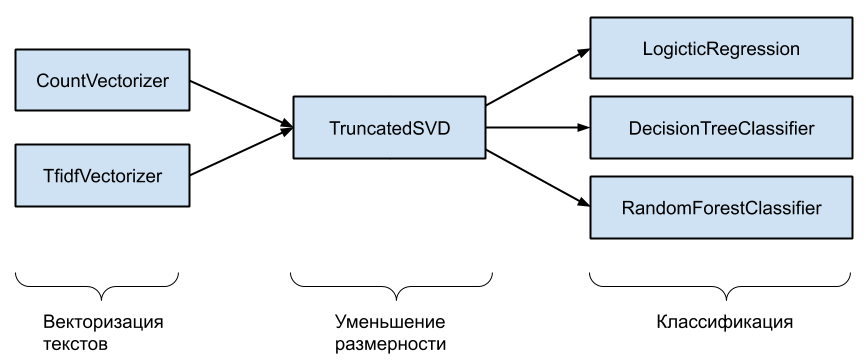

Создаем списки этапов пайплайна и соответствующих классов.

In [10]:
vectorizers = ['countvectorizer', 'tfidfvectorizer']
reductors = ['truncatedsvd']
classifiers = ['logisticregression', 'decisiontreeclassifier', 'randomforestclassifier']

Импортируем необходимые классы.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Создаём словарь с набором всех используемых компонентов пайплайнов.

In [12]:
all_models = {'countvectorizer': CountVectorizer(),
              'tfidfvectorizer': TfidfVectorizer(),
              'truncatedsvd': TruncatedSVD(),
              'logisticregression': LogisticRegression(),
              'decisiontreeclassifier': DecisionTreeClassifier(),
              'randomforestclassifier': RandomForestClassifier()
             }

Создаём словарь с наборами гиперпараметров всех компонентов.

In [13]:
all_params = {'countvectorizer': {'countvectorizer__ngram_range': [(1,1), (1,2)]},
              'tfidfvectorizer': {'tfidfvectorizer__ngram_range': [(1,1), (1,2)]},
              'truncatedsvd': {'truncatedsvd__n_components': [100, 300]},
              'logisticregression': {'logisticregression__C': [0.1, 1, 10]},
              'decisiontreeclassifier': {'decisiontreeclassifier__max_depth': [5, 10, 15],
                                         'decisiontreeclassifier__min_samples_leaf': [1, 2]
                                        },
              'randomforestclassifier': {'randomforestclassifier__n_estimators': [30, 100, 300],
                                         'randomforestclassifier__min_samples_leaf': [1, 2]
                                        }
             }

Импортируем метод, позволяющий в одноуровневом цикле создать все возможные сочетания нескольких параметров, а также метод для создания пйплайнов "на лету" и создаем пустой датафрейм для записи результатов всех экспериментов.

In [14]:
from itertools import product
from sklearn.pipeline import make_pipeline

Создаем пустой датафрейм для сохранения результатов всех экспериментов и запускаем основной цикл, на каждой итерации которого генерируем очередное сочетание всех этапов пайплайна, создаем словарь гиперпараметров для пайплайна, создаем сам пайплайн, выполняем обучение и оценку качества с помощью кросс-валидации, записываем результаты обучения в лог.

In [15]:
df_all_results = pd.DataFrame()

for i, stages in enumerate(product(vectorizers, reductors, classifiers), 1):

    vectorizer, reductor, classifier = stages    
    
    print('Pipeline #', i, ':', stages)

    pipe = make_pipeline(all_models[vectorizer], all_models[reductor], all_models[classifier])
    
    current_params = {}
    current_params.update(all_params[vectorizer])
    current_params.update(all_params[reductor])
    current_params.update(all_params[classifier])
    
    model = GridSearchCV(estimator=pipe, param_grid=current_params,
                         scoring='f1_macro', cv=3, n_jobs=-1)
    model.fit(df_train['text'], df_train['label'])
        
    df_current_results = pd.DataFrame(data={'pipeline': i,
                                            'vectorizer': vectorizer,
                                            'reductor': reductor,
                                            'classifier': classifier,
                                            'params': model.cv_results_['params'],
                                            'score': model.cv_results_['mean_test_score']})
 
    df_all_results = df_all_results.append(df_current_results)

Pipeline # 1 : ('countvectorizer', 'truncatedsvd', 'logisticregression')


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline # 2 : ('countvectorizer', 'truncatedsvd', 'decisiontreeclassifier')
Pipeline # 3 : ('countvectorizer', 'truncatedsvd', 'randomforestclassifier')
Pipeline # 4 : ('tfidfvectorizer', 'truncatedsvd', 'logisticregression')


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline # 5 : ('tfidfvectorizer', 'truncatedsvd', 'decisiontreeclassifier')
Pipeline # 6 : ('tfidfvectorizer', 'truncatedsvd', 'randomforestclassifier')


In [16]:
df_all_results.shape

(120, 6)

В результате получаем лог, состоящий из 120 записей. Сортируем лог в порядке убывания метрики F1 и выбираем три лучших пайплайна.

In [17]:
df_all_results.sort_values(by='score', ascending=False, inplace=True)
df_all_results.head(3)

,pipeline,vectorizer,reductor,classifier,params,score
9,4,tfidfvectorizer,truncatedsvd,logisticregression,"{'logisticregression__C': 10, 'tfidfvectorizer...",0.707118
11,4,tfidfvectorizer,truncatedsvd,logisticregression,"{'logisticregression__C': 10, 'tfidfvectorizer...",0.692201
8,4,tfidfvectorizer,truncatedsvd,logisticregression,"{'logisticregression__C': 10, 'tfidfvectorizer...",0.661929


Таким образом, в данном примере наилучшее качество по метрике F1 показывает классификатор на логистической регрессии с параметром регуляризации С=10 с пространством признаков, полученным с помощью TfidfVectorizer на униграммах и уменьшенным до 300 с помощью TruncatedSVD.

In [18]:
 df_all_results.to_csv('results.csv', sep=';', decimal=',', index=False)

Предложенный способ можно использовать для поиска оптимальных пайплайнов в задачах машинного обучения. Исходый код ноутбука приведен в репозитории github.com/mporuchikov/complex_classification_pipeline.